Status: Optimal
   Flight_ID     Type  Scheduled  Assigned_Slot  Delay_Min  Priority
0      AI101  Landing          5              0         -5         1
1      6E202  Takeoff          8              3         -5         2
2      UK301  Landing         12              6         -6         3
3     VTI404  Takeoff         15             10         -5         2
5      AI106  Landing         20             12         -8         1
4      G8205  Landing         18             16         -2         2
7      UK310  Landing         25             19         -6         2
6      6E209  Takeoff         22             22          0         3
9      AI112  Landing         30             24         -6         1
8      G8210  Takeoff         28             28          0         2
11     UK318  Landing         35             30         -5         2
10     6E215  Takeoff         33             33          0         3
12     G8218  Takeoff         38             35         -3         2
14     6E223  Take

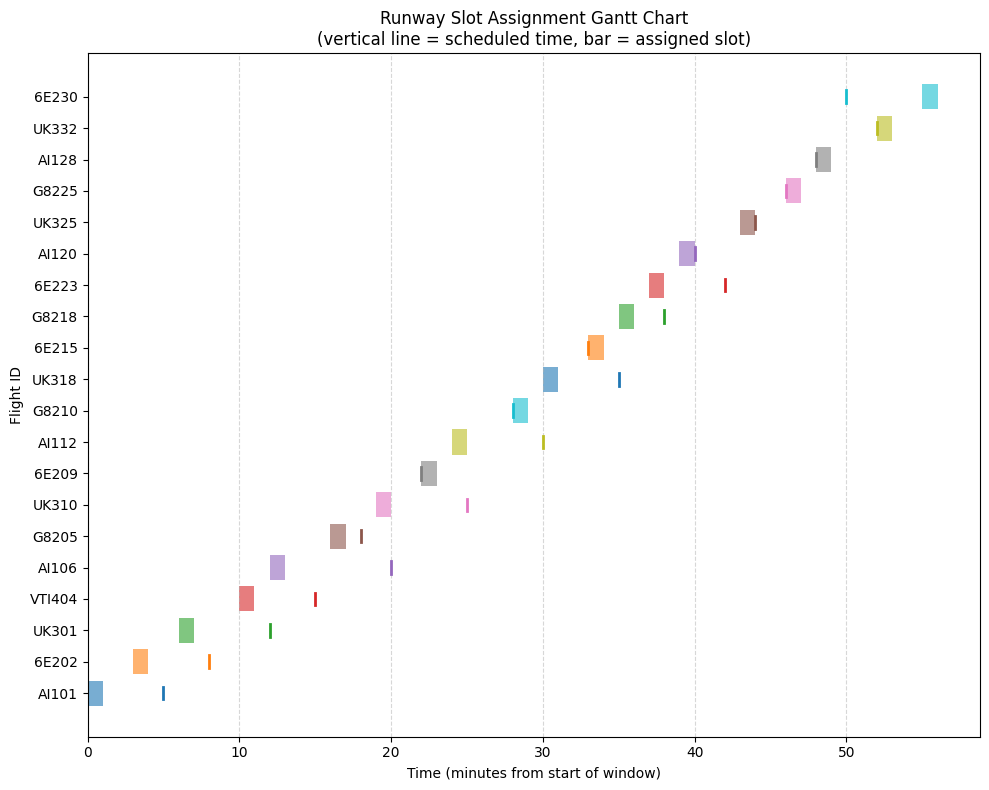

In [1]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load flight dataset
df = pd.read_csv("flights.csv")

# 2. Define time slots for the 1-hour window (0–59 minutes)
slots = list(range(0, 60))

# 3. Create LP model
model = pulp.LpProblem("Runway_Slot_Optimization", pulp.LpMinimize)

# 4. Decision variables x[(i,j)] = 1 if flight i is assigned to slot j
x = {}
for i in df.index:
    for j in slots:
        # Only create variables for slots within [Early, Late]
        if df.loc[i, "Early"] <= j <= df.loc[i, "Late"]:
            x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat="Binary")

# 5. Objective function: minimize total delay cost
priority_weight = {1: 1.5, 2: 1.2, 3: 1.0}

objective_terms = []
for (i, j), var in x.items():
    row = df.loc[i]
    delay = max(0, j - row["Scheduled"])
    weight = priority_weight[row["Priority"]]
    cost_ij = delay * row["Cost"] * weight
    objective_terms.append(cost_ij * var)

model += pulp.lpSum(objective_terms)

# 6. Constraint: each flight gets exactly ONE slot
for i in df.index:
    valid_slots = [x[(i, j)] for j in slots if (i, j) in x]
    model += pulp.lpSum(valid_slots) == 1, f"OneSlot_Flight_{i}"

# 7. Constraint: at most one flight per slot (single runway)
for j in slots:
    vars_in_slot = [x[(i, j)] for i in df.index if (i, j) in x]
    if vars_in_slot:
        model += pulp.lpSum(vars_in_slot) <= 1, f"OneFlight_Per_Slot_{j}"

# 8. Separation constraints
for i in df.index:
    gap_i = int(df.loc[i, "Gap"])
    for k in df.index:
        if i == k:
            continue
        for j in slots:
            if (i, j) in x:
                for sep in range(1, gap_i + 1):
                    j2 = j + sep
                    if j2 in slots and (k, j2) in x:
                        model += x[(i, j)] + x[(k, j2)] <= 1, f"Sep_{i}_{k}_{j}_{j2}"

# 9. Solve
model.solve(pulp.PULP_CBC_CMD(msg=1))

print("Status:", pulp.LpStatus[model.status])

# 10. Extract and display solution
assignments = []
for (i, j), var in x.items():
    if var.value() == 1:
        row = df.loc[i]
        delay = j - row["Scheduled"]
        assignments.append({
            "Flight_ID": row["Flight_ID"],
            "Type": row["Type"],
            "Scheduled": row["Scheduled"],
            "Assigned_Slot": j,
            "Delay_Min": delay,
            "Priority": row["Priority"]
        })

result_df = pd.DataFrame(assignments).sort_values(by="Assigned_Slot")
print(result_df)

# 11. Gantt-style chart of assigned slots vs scheduled times
plt.figure(figsize=(10, 8))

# We'll plot each flight on its own y-position
y_positions = range(len(result_df))
flight_ids = result_df["Flight_ID"].tolist()

for idx, (_, row) in enumerate(result_df.iterrows()):
    y = y_positions[idx]
    scheduled = row["Scheduled"]
    assigned = row["Assigned_Slot"]

    # Plot scheduled time as a vertical marker (small line)
    plt.plot([scheduled, scheduled], [y - 0.2, y + 0.2], linewidth=2)

    # Plot assigned slot as a horizontal bar (length 1 minute)
    plt.barh(y, 1, left=assigned, alpha=0.6)

# Formatting
plt.yticks(y_positions, flight_ids)
plt.xlabel("Time (minutes from start of window)")
plt.ylabel("Flight ID")
plt.title("Runway Slot Assignment Gantt Chart\n(vertical line = scheduled time, bar = assigned slot)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [2]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load flight dataset
df = pd.read_csv("flights_2.csv")

# 2. Define time slots for the 1-hour window (0–59 minutes)
slots = list(range(0, 120))

# 3. Create LP model
model = pulp.LpProblem("Runway_Slot_Optimization", pulp.LpMinimize)

# 4. Decision variables x[(i,j)] = 1 if flight i is assigned to slot j
x = {}
for i in df.index:
    for j in slots:
        # Only create variables for slots within [Early, Late]
        if df.loc[i, "Early"] <= j <= df.loc[i, "Late"]:
            x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat="Binary")

# 5. Objective function: minimize total delay cost
priority_weight = {1: 1.5, 2: 1.2, 3: 1.0}

objective_terms = []
for (i, j), var in x.items():
    row = df.loc[i]
    delay = max(0, j - row["Scheduled"])
    weight = priority_weight[row["Priority"]]
    cost_ij = delay * row["Cost"] * weight
    objective_terms.append(cost_ij * var)

model += pulp.lpSum(objective_terms)

# 6. Constraint: each flight gets exactly ONE slot
for i in df.index:
    valid_slots = [x[(i, j)] for j in slots if (i, j) in x]
    model += pulp.lpSum(valid_slots) == 1, f"OneSlot_Flight_{i}"

# 7. Constraint: at most one flight per slot (single runway)
for j in slots:
    vars_in_slot = [x[(i, j)] for i in df.index if (i, j) in x]
    if vars_in_slot:
        model += pulp.lpSum(vars_in_slot) <= 1, f"OneFlight_Per_Slot_{j}"

# 8. Separation constraints
for i in df.index:
    gap_i = int(df.loc[i, "Gap"])
    for k in df.index:
        if i == k:
            continue
        for j in slots:
            if (i, j) in x:
                for sep in range(1, gap_i + 1):
                    j2 = j + sep
                    if j2 in slots and (k, j2) in x:
                        model += x[(i, j)] + x[(k, j2)] <= 1, f"Sep_{i}_{k}_{j}_{j2}"

# 9. Solve
model.solve(pulp.PULP_CBC_CMD(msg=1))

print("Status:", pulp.LpStatus[model.status])

# 10. Extract and display solution
assignments = []
for (i, j), var in x.items():
    if var.value() == 1:
        row = df.loc[i]
        delay = j - row["Scheduled"]
        assignments.append({
            "Flight_ID": row["Flight_ID"],
            "Type": row["Type"],
            "Scheduled": row["Scheduled"],
            "Assigned_Slot": j,
            "Delay_Min": delay,
            "Priority": row["Priority"]
        })

result_df = pd.DataFrame(assignments).sort_values(by="Assigned_Slot")
print(result_df)

# 11. Gantt-style chart of assigned slots vs scheduled times
plt.figure(figsize=(10, 8))

# We'll plot each flight on its own y-position
y_positions = range(len(result_df))
flight_ids = result_df["Flight_ID"].tolist()

for idx, (_, row) in enumerate(result_df.iterrows()):
    y = y_positions[idx]
    scheduled = row["Scheduled"]
    assigned = row["Assigned_Slot"]

    # Plot scheduled time as a vertical marker (small line)
    plt.plot([scheduled, scheduled], [y - 0.2, y + 0.2], linewidth=2)

    # Plot assigned slot as a horizontal bar (length 1 minute)
    plt.barh(y, 1, left=assigned, alpha=0.6)

# Formatting
plt.yticks(y_positions, flight_ids)
plt.xlabel("Time (minutes from start of window)")
plt.ylabel("Flight ID")
plt.title("Runway Slot Assignment Gantt Chart\n(vertical line = scheduled time, bar = assigned slot)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Status: Infeasible


KeyError: 'Assigned_Slot'

Status: Infeasible
   Flight_ID     Type  Scheduled  Assigned_Slot  Delay_Min  Priority
0      AI101  Landing          5              0         -5         1
1      6E202  Takeoff          8              3         -5         2
2     VTI404  Takeoff         15             12         -3         2
3      6E209  Takeoff         22             15         -7         3
4      UK310  Landing         25             19         -6         2
5      G8210  Takeoff         28             20         -8         2
6      AI112  Landing         30             23         -7         1
7      6E215  Takeoff         33             25         -8         3
8      UK318  Landing         35             27         -8         2
9      G8218  Takeoff         38             30         -8         2
10     AI120  Landing         40             31         -9         1
11     6E223  Takeoff         42             32        -10         3
12     UK325  Landing         44             35         -9         2
13     G8225  T

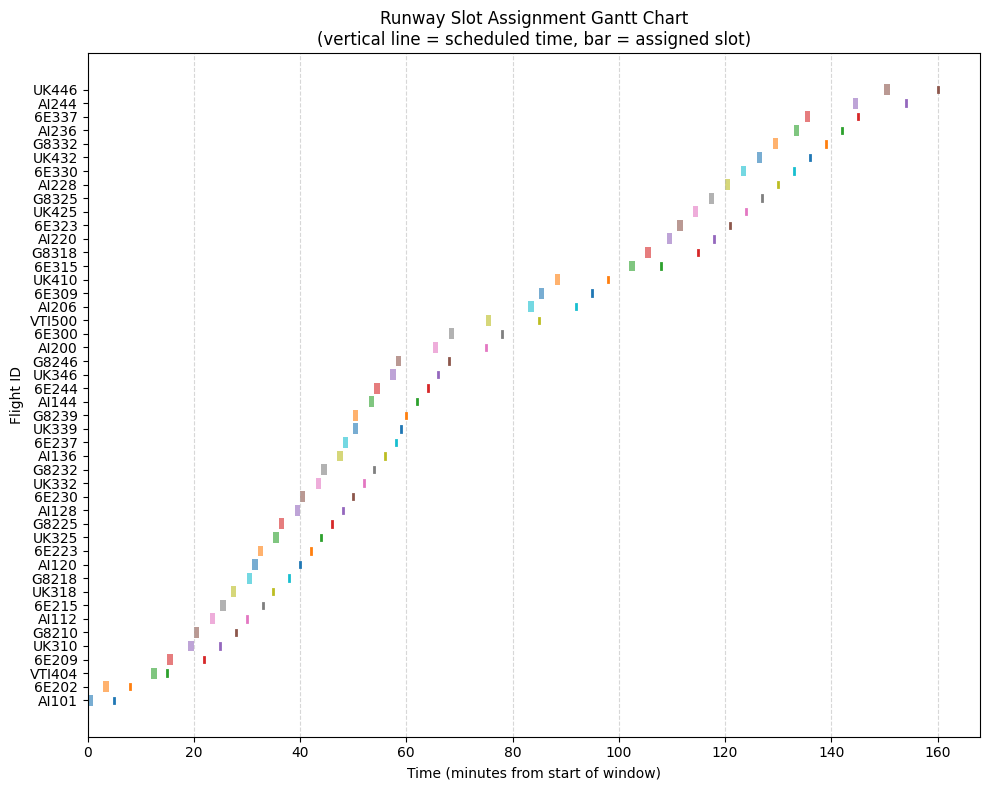

In [ ]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load flight dataset
df = pd.read_csv("flights_4.csv")

# 2. Define time slots for the 1-hour window (0–59 minutes)
slots = list(range(0, 300))

# 3. Create LP model
model = pulp.LpProblem("Runway_Slot_Optimization", pulp.LpMinimize)

# 4. Decision variables x[(i,j)] = 1 if flight i is assigned to slot j
x = {}
for i in df.index:
    for j in slots:
        # Only create variables for slots within [Early, Late]
        if df.loc[i, "Early"] <= j <= df.loc[i, "Late"]:
            x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat="Binary")

# 5. Objective function: minimize total delay cost
priority_weight = {1: 1.5, 2: 1.2, 3: 1.0}

objective_terms = []
for (i, j), var in x.items():
    row = df.loc[i]
    delay = max(0, j - row["Scheduled"])
    weight = priority_weight[row["Priority"]]
    cost_ij = delay * row["Cost"] * weight
    objective_terms.append(cost_ij * var)

model += pulp.lpSum(objective_terms)

# 6. Constraint: each flight gets exactly ONE slot
for i in df.index:
    valid_slots = [x[(i, j)] for j in slots if (i, j) in x]
    model += pulp.lpSum(valid_slots) == 1, f"OneSlot_Flight_{i}"

# 7. Constraint: at most one flight per slot (single runway)
for j in slots:
    vars_in_slot = [x[(i, j)] for i in df.index if (i, j) in x]
    if vars_in_slot:
        model += pulp.lpSum(vars_in_slot) <= 1, f"OneFlight_Per_Slot_{j}"

# 8. Separation constraints
for i in df.index:
    gap_i = int(df.loc[i, "Gap"])
    for k in df.index:
        if i == k:
            continue
        for j in slots:
            if (i, j) in x:
                for sep in range(1, gap_i + 1):
                    j2 = j + sep
                    if j2 in slots and (k, j2) in x:
                        model += x[(i, j)] + x[(k, j2)] <= 1, f"Sep_{i}_{k}_{j}_{j2}"

# 9. Solve
model.solve(pulp.PULP_CBC_CMD(msg=1))

print("Status:", pulp.LpStatus[model.status])

# 10. Extract and display solution
assignments = []
for (i, j), var in x.items():
    if var.value() == 1:
        row = df.loc[i]
        delay = j - row["Scheduled"]
        assignments.append({
            "Flight_ID": row["Flight_ID"],
            "Type": row["Type"],
            "Scheduled": row["Scheduled"],
            "Assigned_Slot": j,
            "Delay_Min": delay,
            "Priority": row["Priority"]
        })

result_df = pd.DataFrame(assignments).sort_values(by="Assigned_Slot")
print(result_df)

# 11. Gantt-style chart of assigned slots vs scheduled times
plt.figure(figsize=(10, 8))

# We'll plot each flight on its own y-position
y_positions = range(len(result_df))
flight_ids = result_df["Flight_ID"].tolist()

for idx, (_, row) in enumerate(result_df.iterrows()):
    y = y_positions[idx]
    scheduled = row["Scheduled"]
    assigned = row["Assigned_Slot"]

    # Plot scheduled time as a vertical marker (small line)
    plt.plot([scheduled, scheduled], [y - 0.2, y + 0.2], linewidth=2)

    # Plot assigned slot as a horizontal bar (length 1 minute)
    plt.barh(y, 1, left=assigned, alpha=0.6)

# Formatting
plt.yticks(y_positions, flight_ids)
plt.xlabel("Time (minutes from start of window)")
plt.ylabel("Flight ID")
plt.title("Runway Slot Assignment Gantt Chart\n(vertical line = scheduled time, bar = assigned slot)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Status: Optimal
   Flight_ID  Scheduled  Assigned  Delay
0       F001          0         0      0
3       F004         18         3    -15
1       F002          6         5     -1
2       F003         12         7     -5
6       F007         36        11    -25
11      F012         66        13    -53
12      F013         72        17    -55
4       F005         24        21     -3
15      F016         90        24    -66
5       F006         30        27     -3
8       F009         48        32    -16
7       F008         42        36     -6
16      F017         96        42    -54
14      F015         84        45    -39
9       F010         54        49     -5
17      F018        102        53    -49
10      F011         60        59     -1
13      F014         78        72     -6
18      F019        108       100     -8
19      F020        114       113     -1


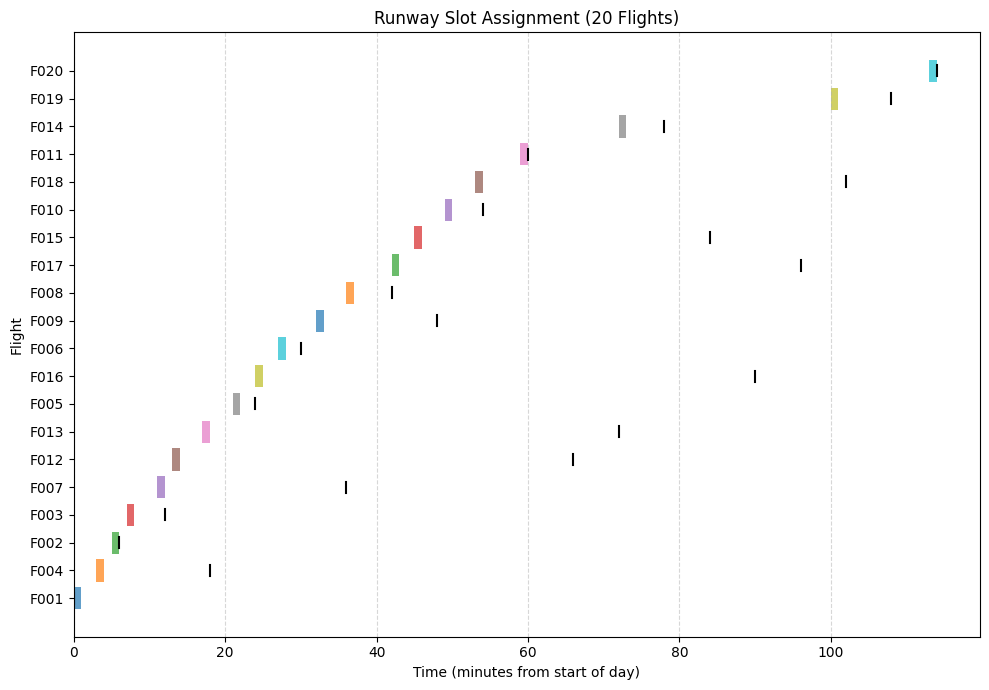

In [5]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load flight dataset
df = pd.read_csv("flights_4_150.csv")

# Ensure numeric types
numeric_cols = ["Scheduled", "Early", "Late", "Priority", "Gap", "Cost"]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=numeric_cols).reset_index(drop=True)
df["Scheduled"] = df["Scheduled"].astype(int)
df["Early"]     = df["Early"].astype(int)
df["Late"]      = df["Late"].astype(int)
df["Priority"]  = df["Priority"].astype(int)
df["Gap"]       = df["Gap"].astype(int)
df["Cost"]      = df["Cost"].astype(float)

# 2. Time slots for full day (0–1439)
slots = list(range(0, 121))

# Clip windows just in case
df["Early"] = df["Early"].clip(0, 1439)
df["Late"]  = df["Late"].clip(0, 1439)

# 3. Create LP model
model = pulp.LpProblem("Runway_Slot_Optimization_20", pulp.LpMinimize)

# 4. Decision variables x[(i,t)] = 1 if flight i at time t
x = {}
for i in df.index:
    for t in slots:
        if df.loc[i, "Early"] <= t <= df.loc[i, "Late"]:
            x[(i, t)] = pulp.LpVariable(f"x_{i}_{t}", cat="Binary")

# 5. Objective function: minimize total delay cost
priority_weight = {1: 1.5, 2: 1.2, 3: 1.0}

model += pulp.lpSum(
    (max(0, t - df.loc[i, "Scheduled"])
     * df.loc[i, "Cost"]
     * priority_weight[df.loc[i, "Priority"]]
     * x[(i, t)])
    for (i, t) in x
)

# 6. Each flight gets exactly one slot
for i in df.index:
    vars_i = [x[(i, t)] for t in slots if (i, t) in x]
    model += pulp.lpSum(vars_i) == 1

# 7. At most one flight per minute
for t in slots:
    vars_t = [x[(i, t)] for i in df.index if (i, t) in x]
    if vars_t:
        model += pulp.lpSum(vars_t) <= 1

# 8. Separation constraints
for i in df.index:
    gap_i = df.loc[i, "Gap"]
    for t in slots:
        if (i, t) in x:
            for dt in range(1, gap_i + 1):
                for k in df.index:
                    if i != k and (k, t + dt) in x:
                        model += x[(i, t)] + x[(k, t + dt)] <= 1

# 9. Solve
solver = pulp.PULP_CBC_CMD(msg=1)
model.solve(solver)

print("Status:", pulp.LpStatus[model.status])

if pulp.LpStatus[model.status] != "Optimal":
    print("Model infeasible or not optimal.")
else:
    # 10. Extract solution
    assignments = []
    for (i, t), var in x.items():
        if var.value() == 1:
            assignments.append({
                "Flight_ID": df.loc[i, "Flight_ID"],
                "Scheduled": df.loc[i, "Scheduled"],
                "Assigned": t,
                "Delay": t - df.loc[i, "Scheduled"]
            })

    result = pd.DataFrame(assignments).sort_values("Assigned")
    print(result)

    # 11. Simple Gantt chart
    plt.figure(figsize=(10, 7))
    for y, (_, row) in enumerate(result.iterrows()):
        # scheduled time: black line
        plt.plot([row["Scheduled"], row["Scheduled"]], [y - 0.2, y + 0.2], color="black")
        # assigned time: blue bar
        plt.barh(y, 1, left=row["Assigned"], alpha=0.7)

    plt.yticks(range(len(result)), result["Flight_ID"])
    plt.xlabel("Time (minutes from start of day)")
    plt.ylabel("Flight")
    plt.title("Runway Slot Assignment (20 Flights)")
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

Status: Optimal
   Flight_ID  Scheduled  Assigned  Delay
0       F001          0         0      0
1       F002          6         3     -3
2       F003         12         5     -7
4       F005         24         9    -15
10      F011         60        12    -48
14      F015         84        15    -69
3       F004         18        17     -1
5       F006         30        22     -8
12      F013         72        26    -46
7       F008         42        28    -14
6       F007         36        31     -5
8       F009         48        33    -15
9       F010         54        36    -18
11      F012         66        41    -25
13      F014         78        45    -33
26      F027        156        51   -105
16      F017         96        53    -43
15      F016         90        70    -20
17      F018        102        80    -22
18      F019        108        84    -24
19      F020        114        86    -28
25      F026        150       102    -48
20      F021        120       110    -10


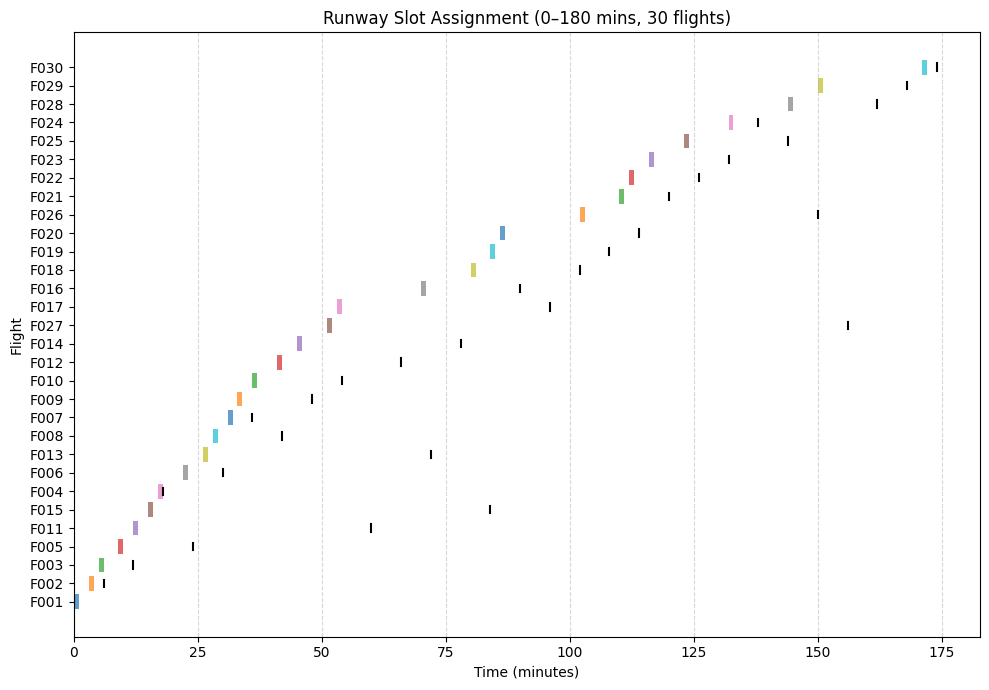

In [9]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load flight dataset
df = pd.read_csv("flights_4_150.csv")

# Ensure numeric columns
numeric_cols = ["Scheduled", "Early", "Late", "Priority", "Gap", "Cost"]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=numeric_cols).reset_index(drop=True)
df["Scheduled"] = df["Scheduled"].astype(int)
df["Early"]     = df["Early"].astype(int)
df["Late"]      = df["Late"].astype(int)
df["Priority"]  = df["Priority"].astype(int)
df["Gap"]       = df["Gap"].astype(int)
df["Cost"]      = df["Cost"].astype(float)

# 2. Time slots for 0–180 minutes
slots = list(range(0, 181))   # 0,1,2,...,180

# 3. Create LP model
model = pulp.LpProblem("Runway_Slot_Optimization_30_180", pulp.LpMinimize)

# 4. Decision variables x[(i,t)] = 1 if flight i at time t
x = {}
for i in df.index:
    for t in slots:
        if df.loc[i, "Early"] <= t <= df.loc[i, "Late"]:
            x[(i, t)] = pulp.LpVariable(f"x_{i}_{t}", cat="Binary")

# 5. Objective function: minimize total weighted delay cost
priority_weight = {1: 1.5, 2: 1.2, 3: 1.0}

model += pulp.lpSum(
    (max(0, t - df.loc[i, "Scheduled"])
     * df.loc[i, "Cost"]
     * priority_weight[df.loc[i, "Priority"]]
     * x[(i, t)])
    for (i, t) in x
)

# 6. Each flight gets exactly ONE slot
for i in df.index:
    vars_i = [x[(i, t)] for t in slots if (i, t) in x]
    model += pulp.lpSum(vars_i) == 1

# 7. At most one flight per minute
for t in slots:
    vars_t = [x[(i, t)] for i in df.index if (i, t) in x]
    if vars_t:
        model += pulp.lpSum(vars_t) <= 1

# 8. Separation constraints
for i in df.index:
    gap_i = df.loc[i, "Gap"]
    for t in slots:
        if (i, t) in x:
            for dt in range(1, gap_i + 1):
                for k in df.index:
                    if i != k and (k, t + dt) in x:
                        model += x[(i, t)] + x[(k, t + dt)] <= 1

# 9. Solve
solver = pulp.PULP_CBC_CMD(msg=1)
model.solve(solver)

print("Status:", pulp.LpStatus[model.status])

if pulp.LpStatus[model.status] != "Optimal":
    print("Model infeasible or not optimal.")
else:
    # 10. Extract solution
    assignments = []
    for (i, t), var in x.items():
        if var.value() == 1:
            assignments.append({
                "Flight_ID": df.loc[i, "Flight_ID"],
                "Scheduled": df.loc[i, "Scheduled"],
                "Assigned": t,
                "Delay": t - df.loc[i, "Scheduled"]
            })

    result = pd.DataFrame(assignments).sort_values("Assigned")
    print(result)

    # 11. Simple Gantt chart
    plt.figure(figsize=(10, 7))
    for y, (_, row) in enumerate(result.iterrows()):
        # Scheduled time: black line
        plt.plot([row["Scheduled"], row["Scheduled"]], [y - 0.2, y + 0.2], color="black")
        # Assigned time: blue bar
        plt.barh(y, 1, left=row["Assigned"], alpha=0.7)

    plt.yticks(range(len(result)), result["Flight_ID"])
    plt.xlabel("Time (minutes)")
    plt.ylabel("Flight")
    plt.title("Runway Slot Assignment (0–180 mins, 30 flights)")
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()